# COGS 108 - Final Project 

# Overview

*Fill in your overview here*

# Names / ID

- Lan Wei       
- Sean Race     
- Weilun Yao    
- Shine Paek     
- Kyosuke Goto    

# Group Members IDs

- A########
- A########
- A########
- A########

# Research Question

*Fill in your research question here*

## Background and Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


*Fill in your hypotheses here*

# Dataset(s)

*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name:
- Link to the dataset:
- Number of observations:

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

# Setup

What modules did we use?

In [1]:
## YOUR CODE HERE
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile

# ADD MORE AS NEEDED

# Data Cleaning

Describe your data cleaning steps here.

TODO: What are we doing


In [2]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

### CDC DATA (https://www.cdc.gov/nchs/data/dvs/Record_Layout_2013.pdf)

In [3]:
## 2013 Data (EXTRACTS ZIP. SLOW.)

# cdcZip   = 'mort2013us.zip'
datafile = 'VS13MORT.DUSMCPUB'

# with ZipFile(cdcZip, 'r') as z:
#     z.extract(datafile)

#! head -5 $datafile

In [4]:
import csv
import io

# Set order of Columns
fields = ['Data year',
          'Manner of Death',
          'Place of Death',
          'Sex',
          'Race',
          'Education Reporting Flag',
          'Education 1989 Revision',
          'Education 2003 Revision',
          'Age Recode 52',
          'Age Recode 27',
          'Age Recode 12',
          'Hispanic origin'
          ]

out = io.StringIO()
cw = csv.DictWriter(out,fields)
cw.writeheader()

# Parse each line of text file for information, save to CSV
with open(datafile,'r') as inFile:
    for line in inFile:
        row = {
            'Education 1989 Revision' :line[60:62],
            'Education 2003 Revision' :line[62],
            'Education Reporting Flag':line[63],
            'Sex'                     :line[68],
            'Age Recode 52'           :line[74:76],
            'Age Recode 27'           :line[76:78],
            'Age Recode 12'           :line[78:80],
            'Place of Death'          :line[82],
            'Data year'               :line[101:105],
            'Manner of Death'         :line[106],
            'Race'                    :line[444:446],
            'Hispanic origin'         :line[483:486]            
          }
        cw.writerow(row)
    
out.seek(0)

# Read tempolary CSV
cdf = pd.read_csv(out, dtype=object)

In [5]:
# Turn empty value into NaN
cdf.replace(to_replace=r'^\s+$', value=np.nan, regex=True, inplace=True)


In [6]:
# Size of Data
display(cdf.shape)

(2601452, 12)

In [7]:
# Missing Value per Column
cdf.isnull().sum()

Data year                         0
Manner of Death              430113
Place of Death                    0
Sex                               0
Race                              0
Education Reporting Flag          0
Education 1989 Revision     2208160
Education 2003 Revision      393292
Age Recode 52                     0
Age Recode 27                     0
Age Recode 12                     0
Hispanic origin                   0
dtype: int64

In [8]:
# Check for Missing Education Data (missing both 1989 and 2003)
no_edu = sum((cdf['Education 1989 Revision'].isnull()) & (cdf['Education 2003 Revision'].isnull()))
assert no_edu == 0

# Only keep row with 'Education 2003 Revision'
cdf = cdf[(cdf['Education Reporting Flag'] == '1')]

# Drop
cdf.drop(labels=['Education 1989 Revision', 'Education Reporting Flag'], axis=1, inplace=True)

cdf.head()

,Data year,Manner of Death,Place of Death,Sex,Race,Education 2003 Revision,Age Recode 52,Age Recode 27,Age Recode 12,Hispanic origin
53204,2013,7,4,F,01,2,41,21,10,100
53205,2013,7,1,F,02,2,43,23,11,100
53206,2013,7,4,M,01,4,44,24,11,100
53207,2013,7,1,F,01,1,43,23,11,100
53208,2013,7,6,F,01,1,45,25,11,100


In [9]:
# No missing Age Data so we will use 'Age Recode 52'

# Drop 'Age Recode 27' and 'Age Recode 12'
cdf.drop(labels=['Age Recode 27', 'Age Recode 12'], axis=1, inplace=True)

# Drop Age below '5-9 years old' (01~26) and above 100 years old (46~51)
age_codes = [ str(i).zfill(2) for i in range(1,27) ] + [ str(i) for i in range(46,52) ]
cdf = cdf[~cdf['Age Recode 52'].isin(age_codes)]

cdf.head()

,Data year,Manner of Death,Place of Death,Sex,Race,Education 2003 Revision,Age Recode 52,Hispanic origin
53204,2013,7,4,F,01,2,41,100
53205,2013,7,1,F,02,2,43,100
53206,2013,7,4,M,01,4,44,100
53207,2013,7,1,F,01,1,43,100
53208,2013,7,6,F,01,1,45,100


In [10]:
# Rename Columns
cdf.rename({'Education 2003 Revision':'Education', 'Age Recode 52':'Age'}, axis=1, inplace=True)
cdf.head()

,Data year,Manner of Death,Place of Death,Sex,Race,Education,Age,Hispanic origin
53204,2013,7,4,F,01,2,41,100
53205,2013,7,1,F,02,2,43,100
53206,2013,7,4,M,01,4,44,100
53207,2013,7,1,F,01,1,43,100
53208,2013,7,6,F,01,1,45,100


In [11]:
# Convert IDs to actual meaning

cause_dict = {  '1': 'Accident',
                '2': 'Suicide',
                '3': 'Homicide',
                '4': 'Pending Investigation',
                '5': 'Could not determine',
                '6': 'Self-Inflicted',
                '7': 'Natural' }

edu_dict = { '1': '8th grade or less',
             '2': '9-12th grade, no diploma',
             '3': 'high school graduate or GED completed',
             '4': 'some college credit, but no degree',
             '5': 'Associate degree',
             '6': "Bachelor's degree",
             '7': "Master's degree",
             '8': 'Doctorate or Professional degree',
             '9': 'Unknown' }

age_dict = { #'01':'Under 1 hour (includes not stated hours and minutes)',
             #'02':'1 - 23 hours',
             #'03':'1 day (includes not stated days)',
             #'04':'2 days',
             #'05':'3 days',
             #'06':'4 days',
             #'07':'5 days',
             #'08':'6 days',
             #'09':'7 - 13 days (includes not stated weeks)',
             #'10':'14 - 20 days',
             #'11':'21 - 27 days',
             #'12':'1 month (includes not stated months)',
             #'13':'2 months',
             #'14':'3 months',
             #'15':'4 months',
             #'16':'5 months',
             #'17':'6 months',
             #'18':'7 months',
             #'19':'8 months',
             #'20':'9 months',
             #'21':'10 months',
             #'22':'11 months',
             #'23':'1 year',
             #'24':'2 years',
             #'25':'3 years',
             #'26':'4 years',
             '27':'5 - 9 years',
             '28':'10 - 14 years',
             '29':'15 - 19 years',
             '30':'20 - 24 years',
             '31':'25 - 29 years',
             '32':'30 - 34 years',
             '33':'35 - 39 years',
             '34':'40 - 44 years',
             '35':'45 - 49 years',
             '36':'50 - 54 years',
             '37':'55 - 59 years',
             '38':'60 - 64 years',
             '39':'65 - 69 years',
             '40':'70 - 74 years',
             '41':'75 - 79 years',
             '42':'80 - 84 years',
             '43':'85 - 89 years',
             '44':'90 - 94 years',
             '45':'95 - 99 years',
             #'46':'100 - 104 years',
             #'47':'105 - 109 years',
             #'48':'110 - 114 years',
             #'49':'115 - 119 years',
             #'50':'120 - 124 years',
             #'51':'125 years and over',
             '52':'Age not stated' }

race_dict = { '01':'White',
              '02':'Black',
              '03':'American Indian (Includes Aleuts and Eskimos)',
              '04':'Chinese',
              '05':'Japanese',
              '06':'Hawaiian (includes Part-Hawaiian)',
              '07':'Filipino',
              '08':'Other Asian or Pacific Islander',
              '18':'Asian Indian',
              '28':'Korean',
              '38':'Samoan',
              '48':'Vietnamese',
              '58':'Guamanian',
              '68':'Other Asian or Pacific Islander',
              '78':'Combined other Asian or Pacific Islander',
              '00':'Other races' }


cdf['Manner of Death'] = cdf['Manner of Death'].map(cause_dict)
cdf['Education'] = cdf['Education'].map(edu_dict)
cdf['Age'] = cdf['Age'].map(age_dict)
cdf['Race'] = cdf['Race'].map(race_dict)


In [12]:
# If cause of death is Suicide
cdf_suicide = cdf[cdf['Manner of Death'] == 'Suicide']

# If cause of death is Natural
cdf_natural = cdf[cdf['Manner of Death'] == 'Natural']

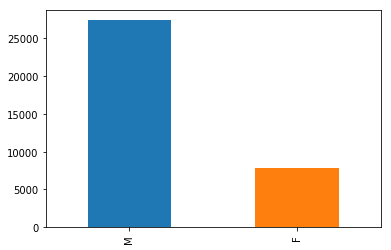

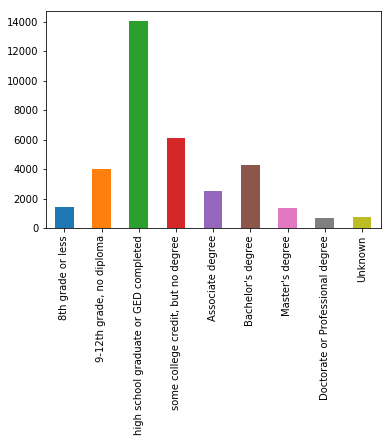

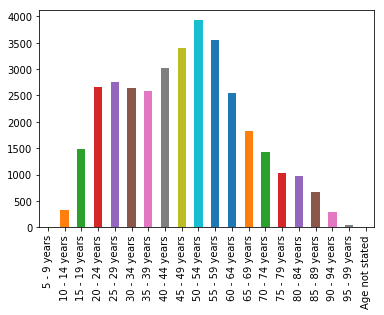

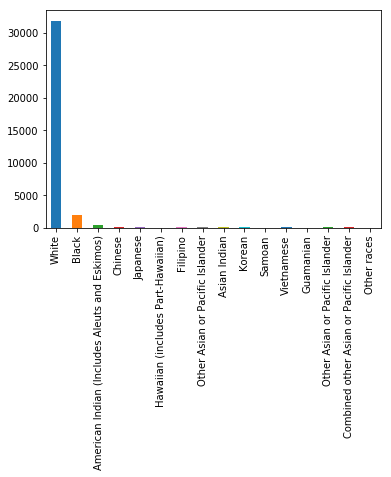

In [13]:
# Suicide Death
plt.show()
cdf_suicide['Sex'].value_counts().plot.bar()
plt.show()
cdf_suicide['Education'].value_counts().reindex(list(edu_dict.values())).plot.bar()
plt.show()
cdf_suicide['Age'].value_counts().reindex(list(age_dict.values())).plot.bar()
plt.show()
cdf_suicide['Race'].value_counts().reindex(list(race_dict.values())).plot.bar()


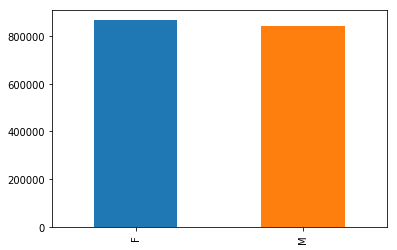

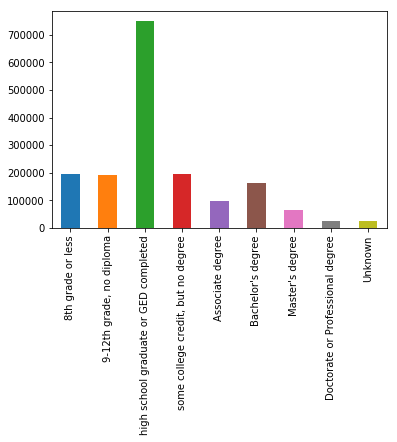

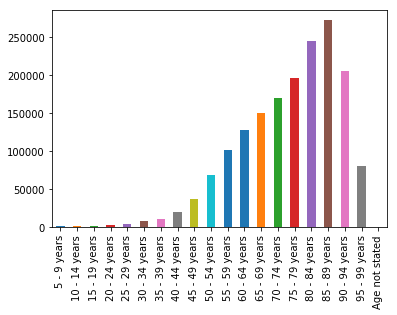

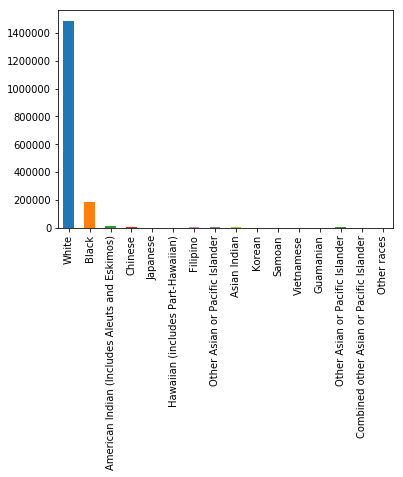

In [14]:
# Natural Death
plt.show()
cdf_natural['Sex'].value_counts().plot.bar()
plt.show()
cdf_natural['Education'].value_counts().reindex(list(edu_dict.values())).plot.bar()
plt.show()
cdf_natural['Age'].value_counts().reindex(list(age_dict.values())).plot.bar()
plt.show()
cdf_natural['Race'].value_counts().reindex(list(race_dict.values())).plot.bar()

# Data Analysis & Results

Include cells that describe the steps in your data analysis.

In [1]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*